In [1]:
import os
import sys
import json
import shutil
import numpy as np
import pandas as pd

In [2]:
# Helper function
def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()
    
def newPath(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def read_json(src_path):
    with open(src_path, 'r') as json_file:
        data = json.load(json_file)
    return data

def write_json(data,dst_path):
    with open(dst_path, 'w') as outfile:
        json.dump(data, outfile)

In [3]:
columns = read_json('../../orderedListGenres.json')
print(len(columns), columns)

20 ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


In [4]:
# 模型輸出儲存的檔案
SAVE_NAME = 'resnet50_trainable_9e-5_starwars'
HISTORY_SAVE = './history/' + SAVE_NAME + '.csv'
WEIGHTS_SAVE = './weight/' + SAVE_NAME + '.h5'

# ResNet50 Model

In [5]:
# read dataframe
train_df = pd.read_csv('../filename2genreMat.csv')
test_df = pd.read_csv('../poster2genreMat.csv')
print(train_df.shape, test_df.shape)

(37959, 22) (165, 22)


In [6]:
valid_df = train_df.sample(frac = 0.2, random_state = 42)
train_df = train_df.drop(valid_df.index)
print(train_df.shape, valid_df.shape)

(30367, 22) (7592, 22)


In [7]:
from keras.applications import ResNet50
from keras import models
from keras.models import Model
from keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator
from keras import layers
from keras import regularizers, optimizers
# from keras.applications.model import ResNet152

Using TensorFlow backend.


In [8]:
# 資料路徑
DATASET_PATH  = '../IGimg'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 20

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 32

# Epoch 數
NUM_EPOCHS = 100

In [9]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(dataframe=train_df,
                                            directory=DATASET_PATH,
                                            x_col="filename",
                                            y_col=columns,
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="other",
                                            target_size=IMAGE_SIZE)

valid_generator=test_datagen.flow_from_dataframe(dataframe=valid_df,
                                                 directory=DATASET_PATH,
                                                 x_col="filename",
                                                 y_col=columns,
                                                 batch_size=BATCH_SIZE,
                                                 seed=42,
                                                 shuffle=True,
                                                 class_mode="other",
                                                 target_size=IMAGE_SIZE)

Found 30367 validated image filenames.
Found 7592 validated image filenames.


# Fixed the last Layer from 1000 classes into N classes

In [10]:
conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.


/home/tonylab/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [11]:
model = models.Sequential()
model.add(conv_base)        # 將卷積基底視為層加入 Sequential 模型中
model.add(layers.AveragePooling2D(pool_size=(7, 7)))
model.add(layers.Flatten()) # 攤平
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid')) # 增加密集層分類器
model.summary() # 查看模型摘要

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 23,575,572
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = True

print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 214
This is the number of trainable weights after freezing the conv base: 214


In [13]:
model.compile(optimizer=Adam(lr=5e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 23,575,572
Non-trainable params: 53,120
_________________________________________________________________


# Training Model

In [14]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

In [15]:
# 訓練模型
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_data = valid_generator,
                              validation_steps = STEP_SIZE_VALID,
                              epochs = NUM_EPOCHS,
                              callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
948/948 [==============================] - 277s 292ms/step - loss: 0.2331 - acc: 0.9060 - val_loss: 0.2289 - val_acc: 0.9124
Epoch 2/100
948/948 [==============================] - 274s 289ms/step - loss: 0.1533 - acc: 0.9398 - val_loss: 0.1805 - val_acc: 0.9298
Epoch 3/100
948/948 [==============================] - 273s 288ms/step - loss: 0.0991 - acc: 0.9619 - val_loss: 0.1829 - val_acc: 0.9302


In [16]:
# 儲存訓練好的模型
model.save(WEIGHTS_SAVE)

In [17]:
# save history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

his_df = pd.DataFrame(data = {
    'Epoch' : epochs,
    'Loss' : loss,
    'Acc' : acc,
    'Val_loss' : val_loss,
    'Val_acc' : val_acc
})
his_df = his_df[['Epoch', 'Loss', 'Acc', 'Val_loss', 'Val_acc']]
his_df.to_csv(HISTORY_SAVE, index = False)

# Plot acc & loss

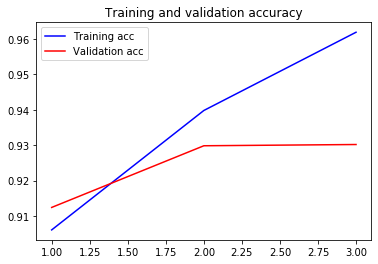

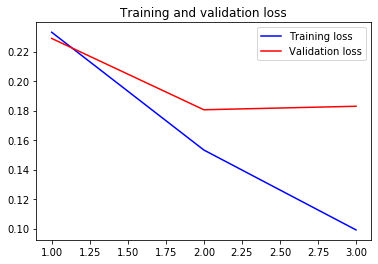

In [18]:
# 繪製結果
import matplotlib.pyplot as plt

plt.figure()

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Testing

### Testing set: Poster

In [19]:
SAVE_NAME = SAVE_NAME + '_poster'

In [20]:
test_df = pd.read_csv('../poster2genreMat.csv')
test_df

,from,filename,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,../Profiles_165/21bridgesmovie/poster.jpeg,21bridgesmovie.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,../Profiles_165/47metersdown/poster.jpeg,47metersdown.jpg,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,../Profiles_165/abeautifuldaymovie/poster.jpeg,abeautifuldaymovie.jpg,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,../Profiles_165/abominablemovie/poster.jpeg,abominablemovie.jpg,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,../Profiles_165/adastramovie/poster.jpeg,adastramovie.jpg,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,../Profiles_165/wrinklestheclown/poster.jpeg,wrinklestheclown.jpg,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
161,../Profiles_165/xmenmovies/poster.jpeg,xmenmovies.jpg,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
162,../Profiles_165/yardiefilm/poster.jpeg,yardiefilm.jpg,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
163,../Profiles_165/yesterdaymovie/poster.jpeg,yesterdaymovie.jpg,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [21]:
DATASET_PATH = '../Poster'

In [23]:
test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=DATASET_PATH,
                                                x_col="filename",
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=IMAGE_SIZE)

Found 165 validated image filenames.


In [24]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [25]:
test_generator.reset()
pred=model.predict_generator(test_generator,
                                     steps=STEP_SIZE_TEST,
                                     verbose=1)

165/165 [==============================] - 13s 77ms/step


# Output

In [26]:
pred.shape

(165, 20)

In [27]:
predictions = pred

results=pd.DataFrame(predictions, columns=columns)
results["filename"] = test_generator.filenames
ordered_cols = ["filename"] + columns
results = results[ordered_cols] #To get the same column order
results.to_csv("./output/"+ SAVE_NAME + "_result.csv",index=False)

## Label top n dynamic

In [28]:
true_df = test_df

In [29]:
results = pd.read_csv("./output/"+ SAVE_NAME + "_result.csv")
results

,filename,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,21bridgesmovie.jpg,0.958552,0.020867,0.000149,0.002855,0.091763,0.803106,0.000908,0.045524,0.000422,...,0.013228,0.056765,0.003401,0.002040,0.000355,0.244649,0.001954,0.193559,0.000401,0.000401
1,47metersdown.jpg,0.867453,0.790908,0.000613,0.000168,0.000749,0.006883,0.000466,0.030773,0.000168,...,0.002473,0.782090,0.000951,0.055939,0.000205,0.715189,0.000342,0.164278,0.000611,0.001039
2,abeautifuldaymovie.jpg,0.006058,0.005848,0.013701,0.967309,0.058642,0.020731,0.000106,0.994284,0.000527,...,0.006257,0.001427,0.021109,0.002129,0.030040,0.003126,0.081754,0.003756,0.014200,0.000854
3,abominablemovie.jpg,0.000197,0.998606,0.999897,0.000228,0.999569,0.000630,0.000246,0.001510,0.000632,...,0.000028,0.000112,0.003022,0.000005,0.000058,0.000033,0.000009,0.000032,0.000105,0.000013
4,adastramovie.jpg,0.166131,0.500061,0.001225,0.003020,0.002541,0.005734,0.002159,0.773414,0.020817,...,0.013977,0.487058,0.001873,0.518866,0.001090,0.024020,0.000675,0.128725,0.005474,0.001149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,wrinklestheclown.jpg,0.001910,0.003286,0.001602,0.041223,0.434896,0.001829,0.189835,0.660974,0.000311,...,0.029547,0.979009,0.058398,0.330933,0.004000,0.007330,0.002597,0.029977,0.011919,0.000785
161,xmenmovies.jpg,0.998099,0.933803,0.000010,0.001033,0.000178,0.003651,0.000365,0.002101,0.000167,...,0.005650,0.001915,0.000395,0.000041,0.000047,0.653491,0.000050,0.011104,0.000096,0.000094
162,yardiefilm.jpg,0.111785,0.006144,0.004126,0.614620,0.225181,0.306530,0.000348,0.973242,0.000278,...,0.018505,0.003713,0.005442,0.017224,0.000647,0.004744,0.004403,0.081920,0.004331,0.001047
163,yesterdaymovie.jpg,0.008731,0.002617,0.012126,0.501051,0.928193,0.049909,0.001007,0.939473,0.001094,...,0.004506,0.014002,0.292241,0.012146,0.022349,0.008760,0.056479,0.006892,0.005108,0.000901


In [30]:
labels = read_json('../../genresDic.json')

In [31]:
def countAcc(predList, trueList):
    fraction = 0
    denominator = len(trueList)
    for g in predList:
        if g in trueList:
            fraction += 1 
    return fraction / denominator

In [32]:
li = []
for i, row in true_df.iterrows():
    username = row['filename']
    if username == results.loc[i,:]['filename']: # username equals
        print(i, username)
        accname = username.split('.')[0]
        truth = labels[accname]
        numTrue = sum(row[2:])
        print('count:', numTrue)
        
        s = results.loc[i,:][1:]
        top_n = s.sort_values(ascending=False)[:numTrue]
        inList = list(top_n.index)
        
        onehot = []
        for g in columns:
            onehot.append(int(g in inList))
            
        accu = countAcc(inList, truth)
        print(accu, inList, truth)
        
        appList = [username, accu, truth, inList] + onehot
        li.append(appList)
        

0 21bridgesmovie.jpg
count: 3
0.6666666666666666 ['Action', 'Crime', 'Sci-Fi'] ['Action', 'Crime', 'Drama']
1 47metersdown.jpg
count: 3
0.6666666666666666 ['Action', 'Adventure', 'Horror'] ['Adventure', 'Drama', 'Horror']
2 abeautifuldaymovie.jpg
count: 2
1.0 ['Drama', 'Biography'] ['Biography', 'Drama']
3 abominablemovie.jpg
count: 3
1.0 ['Animation', 'Comedy', 'Adventure'] ['Adventure', 'Animation', 'Comedy']
4 adastramovie.jpg
count: 3
0.6666666666666666 ['Drama', 'Fantasy', 'Mystery'] ['Adventure', 'Drama', 'Mystery']
5 adogsjourneymovie.jpg
count: 3
1.0 ['Drama', 'Comedy', 'Adventure'] ['Adventure', 'Comedy', 'Drama']
6 aftermathmovie.jpg
count: 3
0.6666666666666666 ['Romance', 'Drama', 'Biography'] ['Drama', 'Romance', 'War']
7 aftermovie.jpg
count: 2
0.5 ['Romance', 'Horror'] ['Drama', 'Romance']
8 ahiddenlifefilm.jpg
count: 3
0.0 ['Thriller', 'Mystery', 'Horror'] ['Biography', 'Drama', 'War']
9 alitamovie.jpg
count: 3
1.0 ['Action', 'Adventure', 'Sci-Fi'] ['Action', 'Adventure'

In [33]:
acc_df = pd.DataFrame(li, columns = ['username', 'acc', 'truth', 'top_n'] + columns)
acc_df

,username,acc,truth,top_n,Action,Adventure,Animation,Biography,Comedy,Crime,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,21bridgesmovie.jpg,0.666667,"[Action, Crime, Drama]","[Action, Crime, Sci-Fi]",1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,47metersdown.jpg,0.666667,"[Adventure, Drama, Horror]","[Action, Adventure, Horror]",1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,abeautifuldaymovie.jpg,1.000000,"[Biography, Drama]","[Drama, Biography]",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abominablemovie.jpg,1.000000,"[Adventure, Animation, Comedy]","[Animation, Comedy, Adventure]",0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,adastramovie.jpg,0.666667,"[Adventure, Drama, Mystery]","[Drama, Fantasy, Mystery]",0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,wrinklestheclown.jpg,0.666667,"[Comedy, Documentary, Horror]","[Horror, Drama, Comedy]",0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
161,xmenmovies.jpg,0.666667,"[Action, Adventure, Sci-Fi]","[Action, Adventure, Fantasy]",1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162,yardiefilm.jpg,0.500000,"[Crime, Drama]","[Drama, Biography]",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
163,yesterdaymovie.jpg,0.333333,"[Comedy, Fantasy, Music]","[Drama, Comedy, Biography]",0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
acc_df.to_csv("./output/"+ SAVE_NAME + "_bi.csv", index = 0)

In [35]:
acc_df['acc'].mean()

0.7181818181818181

# Feature Extraction
## 測試reload model準確度

In [ ]:
SAVE_NAME = 'test'
DATASET_PATH = '../Poster'

In [ ]:
WEIGHTS_LOAD = './weight/resnet50_trainable_9e-5_newdata.h5'

from keras.models import load_model

model = load_model(WEIGHTS_LOAD)

In [ ]:
model.summary()

In [ ]:
test_df = pd.read_csv('../poster2genreMat.csv')
test_df

In [ ]:
test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=DATASET_PATH,
                                                x_col="filename",
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=IMAGE_SIZE)

In [ ]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [ ]:
test_generator.reset()
pred=model.predict_generator(test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1)

In [ ]:
pred.shape

In [ ]:
predictions = pred

results=pd.DataFrame(predictions, columns=columns)
results["filename"] = test_generator.filenames
ordered_cols = ["filename"] + columns
results = results[ordered_cols] #To get the same column order
results.to_csv("./output/"+ SAVE_NAME + "_result.csv",index=False)

In [ ]:
true_df = test_df
labels = read_json('../../genresDic.json')

In [ ]:
def countAcc(predList, trueList):
    fraction = 0
    denominator = len(trueList)
    for g in predList:
        if g in trueList:
            fraction += 1 
    return fraction / denominator

In [ ]:
li = []
for i, row in true_df.iterrows():
    username = row['filename']
    if username == results.loc[i,:]['filename']: # username equals
        print(i, username)
        accname = username.split('.')[0]
        truth = labels[accname]
        numTrue = sum(row[2:])
        print('count:', numTrue)
        
        s = results.loc[i,:][1:]
        top_n = s.sort_values(ascending=False)[:numTrue]
        inList = list(top_n.index)
        
        onehot = []
        for g in columns:
            onehot.append(int(g in inList))
            
        accu = countAcc(inList, truth)
        print(accu, inList, truth)
        
        appList = [username, accu, truth, inList] + onehot
        li.append(appList)
        

In [ ]:
acc_df = pd.DataFrame(li, columns = ['username', 'acc', 'truth', 'top_n'] + columns)
acc_df['acc'].mean()

## 萃取97部電影imdb的feature

### Poster Feature Vector

In [ ]:
test_generator

In [ ]:
extract_layer = Model(inputs=model.input,
                      outputs=model.get_layer('dense_3').output)
#以这个model的预测值作为输出
extract_output = extract_layer.predict_generator(test_generator,
                                                 steps=STEP_SIZE_TEST,
                                                 verbose=1)
print(extract_output.shape)

In [ ]:
idx = test_generator.filenames
print(len(idx), idx)

In [ ]:
res=pd.DataFrame(extract_output, index = idx)
res

In [ ]:
res.to_csv("./output/PosterFeatureVec.csv", header=False)

### IG images

In [ ]:
DATASET_PATH  = '../IGimg'
train_df = pd.read_csv('../filename2genreMat.csv')
train_df

In [ ]:
train_generator=datagen.flow_from_dataframe(dataframe=train_df,
                                            directory=DATASET_PATH,
                                            x_col="filename",
                                            batch_size=1,
                                            seed=42,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=IMAGE_SIZE)

In [ ]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
print(STEP_SIZE_TRAIN)

In [ ]:
extract_layer = Model(inputs=model.input,
                      outputs=model.get_layer('dense_3').output)
#以这个model的预测值作为输出
extract_output = extract_layer.predict_generator(train_generator,
                                                 steps=STEP_SIZE_TRAIN,
                                                 verbose=1)
print(extract_output.shape)

In [ ]:
idx = train_generator.filenames
print(len(idx), idx)

In [ ]:
res=pd.DataFrame(extract_output, index = idx)
res

In [ ]:
res.to_csv("./output/IGimgFeatureVec.csv", header=False)